# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive

MyDrive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [4]:
! ls

 knowledge_distillation
 mind_dataset
 mind_news_data_process_click.ipynb
 mind_news_data_process.ipynb
 mind_news_entity.ipynb
'mind_news_knowledge_distillation _category.ipynb'
'mind_news_knowledge_distillation _category_tuning.ipynb'
 mind_news_knowledge_distillation_ctr.ipynb
 README.md
 restricted_boltzmann_machines_movie_recommendation.ipynb
 wip_jupyter_notebooks


# Install transformer

https://huggingface.co/transformers/installation.html

In [5]:
! pip install transformers
# ! pip install sentencepiece

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 82.8 MB/s 
     |████████████████████████████████| 895 kB 68.7 MB/s 
     |████████████████████████████████| 3.3 MB 22.4 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Import modules

In [6]:
import os
import re
import time
import random
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from wordcloud import WordCloud

import torch
from torch import nn
import torch.nn.functional as F
import torchtext
# from transformers import AutoModel, AutoTokenizer
import torch.optim as optim

from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree
import re



from sklearn.manifold import TSNE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [7]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"
select_text_flag = "title"
select_label_flag = "click_prob_flag" # category_flag # click_prob_flag
model_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/knowledge_distillation/trained_models/"

## set up environment

In [8]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [9]:
ls knowledge_distillation/

data_process.py      model_evaluation.py  __pycache__/
__init__.py          model_kd.py          set_up_environment.py
model_distilbert.py  model_lstm.py        trained_models/
model_doc2vec.py     model_word2vec.py


In [10]:
from knowledge_distillation.set_up_environment import set_random_seed, set_up_gpu

In [11]:
set_random_seed(999)
# device = set_up_gpu()
# print(device)

In [12]:
# Clear memory
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      

In [13]:
import torch
torch.backends.cudnn.enabled=False

# process data

In [14]:
from knowledge_distillation.data_process import DataProcessing

In [15]:
dp = DataProcessing()
data_df_train = dp.get_data(data_path_train, select_text_flag, select_label_flag)
data_df_test = dp.get_data(data_path_test, select_text_flag, select_label_flag)

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0


In [16]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())
print("num_classes", num_classes)

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
display(select_data_df_train[select_data_df_train["label"]==1].head(5))
display(select_data_df_test[select_data_df_test["label"]==1].head(5))

num_classes 2
0    32812
1       23
Name: label, dtype: int64
0    22252
1        4
Name: label, dtype: int64


,text,label
984,Trailer - After the Wedding,1
15216,New Mexico game vs. Air Force rescheduled after lineman Nahje Flowers' death,1
21929,"The day IMS and IndyCar sold to Penske: 'Everybody was like, say what?' Tony Kanaan",1
24260,No guarantees for Frank Ntilikina as Fizdale says starting PG will be determined by form once Elfrid Payton returns,1
24484,Could a trade scenario be in play for the Bengals in the 2020 NFL Draft?,1


,text,label
20206,NYY news: Miggy on the move?,1
20283,Myles Garrett suspension: Browns owner Jimmy Haslam releases statement,1
21263,Heritage upsets Vista PEAK in 4A playoffs,1
21761,'Feed the beast!': Here's what happened in Tacko Fall's Red Claws home debut,1


In [17]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
0    32812
1       23
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
0    22252
1        4
Name: label, dtype: int64


In [18]:
select_data_df_train.head()

,text,label,text_clean,text_len,text_word_count
0,Should NFL be able to fine players for criticizing officiating?,0,should nfl be able to fine players for criticizing officiating,62,10
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0,as eagles take their bye a look at how the defense has improved lately early birds,82,16
2,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0,rye football wins rendition of the game clobbers harrison,57,9
3,"John Dorsey admits talks with Washington, but it ""takes two to tango""",0,john dorsey admits talks with washington but it takes two to tango,66,12
4,"Michigan finally shows some fight, but can't seal the deal",0,michigan finally shows some fight but cant seal the deal,56,10


# process text

In [19]:
import string
def remove_punctuation(text):
    # remove links,remove punctuation and remove words containing numbers.
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [20]:
select_data_df_train['text_process'] = select_data_df_train['text'].apply(str).apply(lambda x: remove_punctuation(x))
select_data_df_train.head()

,text,label,text_clean,text_len,text_word_count,text_process
0,Should NFL be able to fine players for criticizing officiating?,0,should nfl be able to fine players for criticizing officiating,62,10,Should NFL be able to fine players for criticizing officiating
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0,as eagles take their bye a look at how the defense has improved lately early birds,82,16,As Eagles take their bye a look at how the defense has improved lately Early Birds
2,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0,rye football wins rendition of the game clobbers harrison,57,9,Rye football wins rendition of The Game clobbers Harrison
3,"John Dorsey admits talks with Washington, but it ""takes two to tango""",0,john dorsey admits talks with washington but it takes two to tango,66,12,John Dorsey admits talks with Washington but it takes two to tango
4,"Michigan finally shows some fight, but can't seal the deal",0,michigan finally shows some fight but cant seal the deal,56,10,Michigan finally shows some fight but cant seal the deal


In [21]:
select_data_df_test['text_process'] = select_data_df_test['text'].apply(str).apply(lambda x: remove_punctuation(x))
select_data_df_test.head()

,text,label,text_clean,text_process
0,Should NFL be able to fine players for criticizing officiating?,0,should nfl be able to fine players for criticizing officiating,Should NFL be able to fine players for criticizing officiating
1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0,rye football wins rendition of the game clobbers harrison,Rye football wins rendition of The Game clobbers Harrison
2,"John Dorsey admits talks with Washington, but it ""takes two to tango""",0,john dorsey admits talks with washington but it takes two to tango,John Dorsey admits talks with Washington but it takes two to tango
3,"Michigan finally shows some fight, but can't seal the deal",0,michigan finally shows some fight but cant seal the deal,Michigan finally shows some fight but cant seal the deal
4,PGA Tour winners,0,pga tour winners,PGA Tour winners


## NER example

In [22]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('treebank')

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [23]:
sentence = "Apple employees eat apple and Apple at Apple"

In [24]:
token = nltk.word_tokenize(sentence)
token_tag = nltk.pos_tag(token)
index = 1
for chunk in nltk.ne_chunk(token_tag):
    if hasattr(chunk, 'label'):
        print(index, chunk)
    index += 1

1 (GPE Apple/NNP)
6 (PERSON Apple/NNP)
8 (ORGANIZATION Apple/NNP)


In [25]:
ner_results = nlp(sentence)
for i in range(len(ner_results)):
    print(ner_results[i])

{'entity': 'B-ORG', 'score': 0.99894875, 'index': 1, 'word': 'Apple', 'start': 0, 'end': 5}
{'entity': 'B-ORG', 'score': 0.9976597, 'index': 6, 'word': 'Apple', 'start': 30, 'end': 35}
{'entity': 'B-ORG', 'score': 0.99550945, 'index': 8, 'word': 'Apple', 'start': 39, 'end': 44}


# process words

In [26]:
df_texts_train = select_data_df_train[["label","text_process"]]
df_texts_test = select_data_df_test[["label","text_process"]]
display(df_texts_train.head())
display(df_texts_test.head())

,label,text_process
0,0,Should NFL be able to fine players for criticizing officiating
1,0,As Eagles take their bye a look at how the defense has improved lately Early Birds
2,0,Rye football wins rendition of The Game clobbers Harrison
3,0,John Dorsey admits talks with Washington but it takes two to tango
4,0,Michigan finally shows some fight but cant seal the deal


,label,text_process
0,0,Should NFL be able to fine players for criticizing officiating
1,0,Rye football wins rendition of The Game clobbers Harrison
2,0,John Dorsey admits talks with Washington but it takes two to tango
3,0,Michigan finally shows some fight but cant seal the deal
4,0,PGA Tour winners


In [28]:
df_texts_train[df_texts_train["label"]==1].head(10)

,label,text_process
984,1,Trailer After the Wedding
15216,1,New Mexico game vs Air Force rescheduled after lineman Nahje Flowers death
21929,1,The day IMS and IndyCar sold to Penske Everybody was like say what Tony Kanaan
24260,1,No guarantees for Frank Ntilikina as Fizdale says starting PG will be determined by form once Elfrid Payton returns
24484,1,Could a trade scenario be in play for the Bengals in the NFL Draft
24501,1,Cincinnati Beats Drake for First Win of John Brannen Era
24530,1,Steelers fans are ready to pay fine for Maurkice Pouncey who says he doesnt care if hes suspended
25593,1,NFL Reviewing Myles Garretts Helmet Swing In Steelers Game
25866,1,He could have killed him Reaction pouring in after Browns DE hits Steelers QB with helmet
26315,1,Mike Conleys return to Memphis feels really weird for Grizzlies alltime leading scorer


In [29]:
df_texts_train[12:17]

,label,text_process
12,0,Colts News Chris Ballard on first half of season rookie development trade deadline
13,0,Randalls Rant Is Tiger already the GOAT without majors
14,0,Stetsons Jalen Leary making big impact despite size
15,0,LiveAction Disney Movies in the Works After Maleficent Mistress of Evil Photos
16,0,Tracker Ryan Blaney has now finished in every possible position


In [30]:
# def seperate_words_from_texts(df_texts):
#     words = []
#     labels = []
#     for lines, sentence in enumerate(df_texts['text_process']):
#     # for lines, sentence in enumerate(df_texts['text_clean'][:16]):
#         # print(lines, sentence)
#         word_list = sentence.split(" ")
#         for item in word_list:
#             words.append(item)
#             labels.append(df_texts['label'][lines])
#     df_select_words = pd.DataFrame(zip(words, labels), columns=["words", "label_prob"])
#     df_words = df_select_words.groupby("words").agg(['mean', 'count'])
#     df_words.columns = ['_'.join(col) for col in df_words.columns]
#     df_words["labels"] = np.ceil(df_words["label_prob_mean"] / 0.25) * 0.25
#     print("\n", df_words["labels"].unique())
#     print("texts_len:", len(df_texts))
#     print("words_len:", len(df_words))
#     return df_words.reset_index()
# df_words = seperate_words_from_texts(df_train_texts[:16])
# df_words.head(5)

In [31]:
# df_words["label_prob_count"].value_counts().head()
# sns.distplot(df_words["label_prob_count"])

In [32]:
# from nltk.corpus import treebank
# t = treebank.parsed_sents('wsj_0001.mrg')[0]
# # t.draw()
# t

In [33]:
# df_texts[:100]

In [34]:
def identify_entities_and_label_words(df_texts):
    df_list = []
    for lines, sentence in enumerate(df_texts['text_process']):
        # print(lines, sentence)
        
        # tokenize words and get entities
        token = nltk.word_tokenize(sentence)
        token_tag = nltk.pos_tag(token)
        entities_flag_list = []
        chunk_list = []
        for chunk in nltk.ne_chunk(token_tag):
            if hasattr(chunk, 'label'):
                entities_flag = 1
                chunk_flag = chunk[0][0]
            else:
                entities_flag = 0
                chunk_flag = chunk[0]
            chunk_list.append(chunk_flag)
            entities_flag_list.append(entities_flag)

        # get labels
        labels = []
        word_list = sentence.split(" ")
        for item in word_list:
            labels.append(df_texts['label'][lines])

        # combine data to df
        df_tag = pd.DataFrame(token_tag, columns=["words", "pos_tag"]).reset_index()
        df_labels = pd.DataFrame(zip(word_list, labels), columns=["words2","label_prob"]).reset_index()
        df_entities = pd.DataFrame(zip(chunk_list, entities_flag_list), columns=["chunk_list", "entities_flag"]).reset_index()
        
        df_tag.set_index("index", inplace=True)
        df_labels.set_index("index", inplace=True)
        df_combine = df_tag.join(df_labels, how='left')
        df_entities.set_index("index", inplace=True)
        df_combine = pd.merge(df_combine, df_entities, how='left', left_on="words", right_on="chunk_list")
        df_list.append( df_combine )
    df_select_words = pd.concat(df_list, ignore_index=True)
    df_words = df_select_words.groupby("words").agg(['max', 'mean', 'count'])
    df_words.columns = ['_'.join(col) for col in df_words.columns]

    df_words["labels"] = np.ceil(df_words["label_prob_mean"] / 0.25) * 0.25
    df_words["entities_flag"] = np.ceil(df_words["entities_flag_mean"] / 0.5) * 0.5
    print("\n", df_words["labels"].unique())
    print("texts_len:", len(df_texts))
    print("words_len:", len(df_words))
    return df_words.reset_index(), df_select_words

In [37]:
%%time
print(len(df_texts_train))
df_words2, df_select_words = identify_entities_and_label_words(df_texts_train)
print(df_words2["labels"].unique())
display(df_words2.sort_values("labels").head())
display(df_words2.sort_values("labels").tail())

32835

 [0.25 0.   1.   0.5 ]
texts_len: 32835
words_len: 27509
[0.25 0.   1.   0.5 ]


,words,label_prob_max,label_prob_mean,label_prob_count,entities_flag_max,entities_flag_mean,entities_flag_count,labels,entities_flag
13754,Speech,0.0,0.0,6,1.0,0.5,2,0.0,0.5
18307,competition,0.0,0.0,19,0.0,0.0,19,0.0,0.0
18306,competing,0.0,0.0,5,0.0,0.0,5,0.0,0.0
18305,competes,0.0,0.0,2,0.0,0.0,2,0.0,0.0
18304,competent,0.0,0.0,1,0.0,0.0,1,0.0,0.0


,words,label_prob_max,label_prob_mean,label_prob_count,entities_flag_max,entities_flag_mean,entities_flag_count,labels,entities_flag
14399,Tails,1.0,1.0,1,0.0,0.0,1,1.0,0.0
11691,Punishment,1.0,1.0,1,NaN,NaN,0,1.0,NaN
6639,Histrionics,1.0,1.0,1,NaN,NaN,0,1.0,NaN
23531,pouring,1.0,1.0,1,0.0,0.0,1,1.0,0.0
3048,Conleys,1.0,1.0,1,1.0,1.0,1,1.0,1.0


CPU times: user 5min 44s, sys: 4.01 s, total: 5min 48s
Wall time: 5min 45s


In [38]:
%%time
print(len(df_texts_test))
df_words2_test, df_select_words_test = identify_entities_and_label_words(df_texts_test)
print(df_words2_test["labels"].unique())
display(df_words2_test.sort_values("labels").head())
display(df_words2_test.sort_values("labels").tail())

22256

 [0.   0.25 0.5  1.  ]
texts_len: 22256
words_len: 22618
[0.   0.25 0.5  1.  ]


,words,label_prob_max,label_prob_mean,label_prob_count,entities_flag_max,entities_flag_mean,entities_flag_count,labels,entities_flag
0,A,0.0,0.0,263,0.0,0.0,248,0.0,0.0
15074,customer,0.0,0.0,1,0.0,0.0,1,0.0,0.0
15073,custom,0.0,0.0,2,0.0,0.0,2,0.0,0.0
15072,custody,0.0,0.0,2,0.0,0.0,2,0.0,0.0
15071,cussing,0.0,0.0,1,0.0,0.0,1,0.0,0.0


,words,label_prob_max,label_prob_mean,label_prob_count,entities_flag_max,entities_flag_mean,entities_flag_count,labels,entities_flag
4031,Feed,1.0,0.5,2,1.0,0.5,2,0.5,0.5
7658,Miggy,1.0,1.0,1,1.0,1.0,1,1.0,1.0
8620,PEAK,1.0,1.0,1,NaN,NaN,0,1.0,NaN
5087,Haslam,1.0,1.0,1,NaN,NaN,0,1.0,NaN
13831,beast,1.0,1.0,1,0.0,0.0,1,1.0,0.0


CPU times: user 3min 54s, sys: 2.3 s, total: 3min 56s
Wall time: 3min 54s


## check results

In [39]:
df_words2[["entities_flag_max","labels"]].value_counts()

entities_flag_max  labels
0.0                0.00      14323
1.0                0.00       9834
0.0                0.25        104
1.0                0.25         95
                   0.50          9
0.0                0.50          4
                   1.00          3
1.0                1.00          1
dtype: int64

In [40]:
df_words2[["entities_flag","labels"]].value_counts()

entities_flag  labels
0.0            0.00      14323
1.0            0.00       8433
0.5            0.00       1401
0.0            0.25        104
1.0            0.25         73
0.5            0.25         22
1.0            0.50          8
0.0            0.50          4
               1.00          3
1.0            1.00          1
0.5            0.50          1
dtype: int64

In [41]:
df_words2_test[["entities_flag","labels"]].value_counts()

entities_flag  labels
0.0            0.00      12218
1.0            0.00       6707
0.5            0.00       1059
0.0            0.25         16
1.0            0.25          9
0.5            0.25          2
1.0            1.00          1
0.5            0.50          1
0.0            1.00          1
dtype: int64

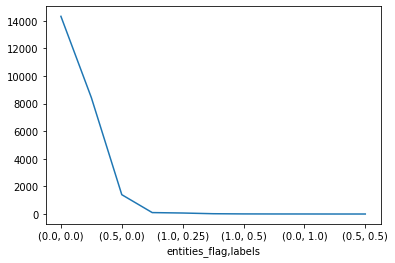

In [42]:
df_words2[["entities_flag","labels"]].value_counts().plot()

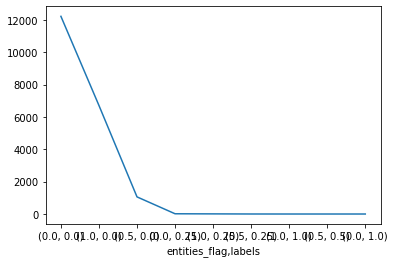

In [43]:
df_words2_test[["entities_flag","labels"]].value_counts().plot()

In [44]:
df_words2[["labels"]].value_counts()

labels
0.00      27288
0.25        199
0.50         14
1.00          8
dtype: int64

               entities_flag    labels
entities_flag       1.000000  0.010615
labels              0.010615  1.000000


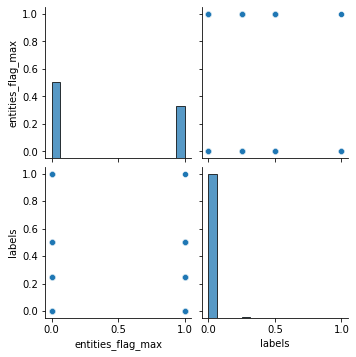

In [45]:
print(df_words2[["entities_flag","labels"]].corr())
sns.pairplot(df_words2[["entities_flag_max","labels"]])

In [46]:
# df_words2.sort_values("entities_flag", ascending=False).head(10)

In [47]:
# df_words2[df_words2["entities_flag"]==0.5].head(10)

In [48]:
# df_select_words[df_select_words["words"]=="Eagles"].head()

In [49]:
sentence = "Apple employees eat apple and Apple at Apple"
token = nltk.word_tokenize(sentence)
token_tag = nltk.pos_tag(token)
entities_flag_list = []
chunk_list = []
index = 1
for chunk in nltk.ne_chunk(token_tag):
    print(index, chunk)
    if hasattr(chunk, 'label'):
        entities_flag = 1
        chunk_flag = chunk[0][0]
    else:
        entities_flag = 0
        chunk_flag = chunk[0]
    chunk_list.append(chunk_flag)
    entities_flag_list.append(entities_flag)
    index += 1

# print(chunk_list)
# print(entities_flag_list)

1 (GPE Apple/NNP)
2 ('employees', 'NNS')
3 ('eat', 'VBP')
4 ('apple', 'NN')
5 ('and', 'CC')
6 (PERSON Apple/NNP)
7 ('at', 'IN')
8 (ORGANIZATION Apple/NNP)


# Knowledge graph

In [50]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

In [80]:
dftt = df_texts_train.head(10000)
dftt.head()

,label,text_process
0,0,Should NFL be able to fine players for criticizing officiating
1,0,As Eagles take their bye a look at how the defense has improved lately Early Birds
2,0,Rye football wins rendition of The Game clobbers Harrison
3,0,John Dorsey admits talks with Washington but it takes two to tango
4,0,Michigan finally shows some fight but cant seal the deal


## examples with sentence relationships

In [81]:
# Ref: https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

In [82]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

entity_pairs = []

for i in tqdm(dftt["text_process"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 10000/10000 [01:07<00:00, 148.95it/s]


In [83]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)
relations = [get_relation(i) for i in tqdm(dftt['text_process'])]

100%|██████████| 10000/10000 [01:08<00:00, 146.12it/s]


In [84]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,NFL,officiating,be able
1,how defense,Early Birds,take
2,Rye football,Game clobbers,wins
3,it,two,admits
4,Michigan,finally deal,shows


In [85]:
kg_df["edge"].value_counts()[:10]

says      145
is        139
has        62
wins       59
are        53
be         53
Watch      52
have       52
things     50
Week       47
Name: edge, dtype: int64

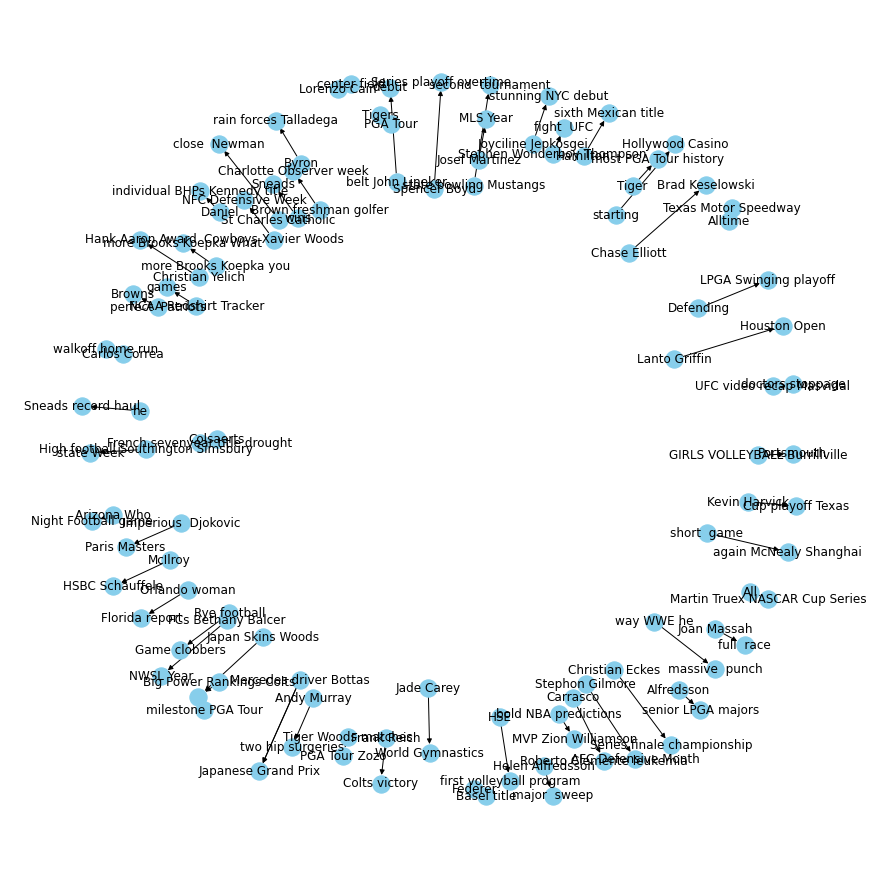

In [90]:
# create a directed-graph from a dataframe
df_plot = kg_df[kg_df['edge']=="wins"]
G=nx.from_pandas_edgelist(df_plot, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', 
        edge_cmap=plt.cm.Blues, pos = pos, arrowsize=10)
plt.show()

## build knowledge graph

In [ ]:
dft = df_words2.head(10)
source = df_words2["words"].head(10)
target = df_words2["words"].tail(10)
relations = df_words2["labels"].head(10)

In [63]:
# # extract source and target
# source = [i[0] for i in entity_pairs]
# target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,A,NaN,0.25
1,AA,NaN,0.00
2,AAA,NaN,0.00
3,AAAA,NaN,0.00
4,AAC,NaN,0.00


In [64]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

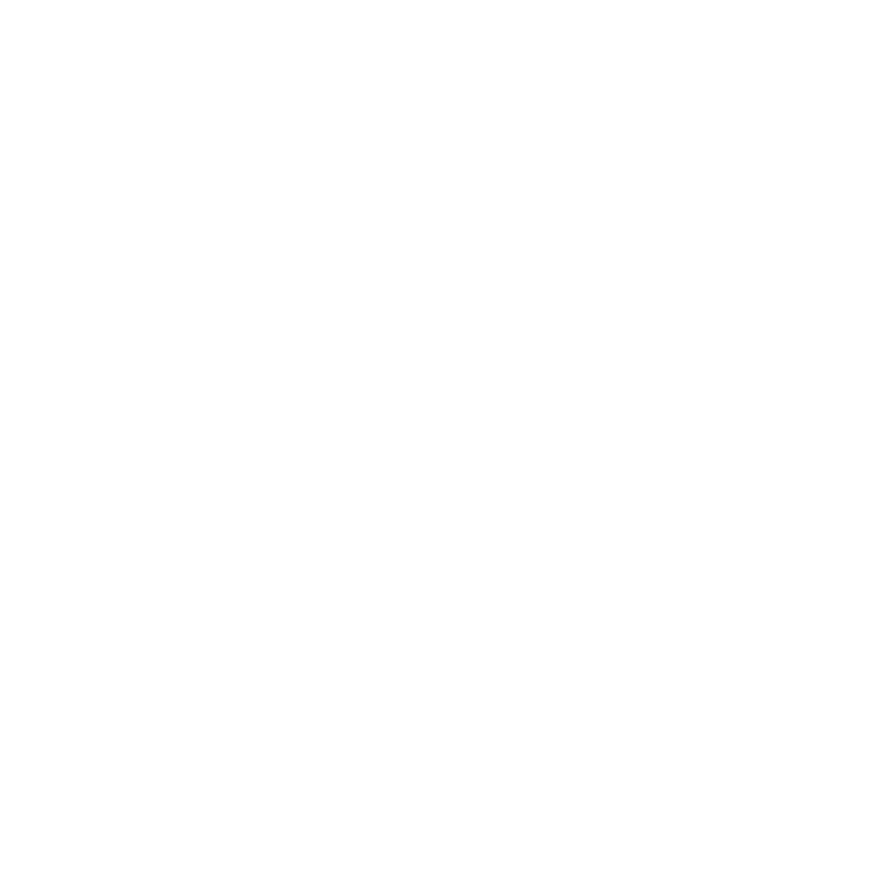

In [66]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Embedding

In [ ]:
from gensim.models import word2vec

In [ ]:
df_words.tail()

In [ ]:
df_words["words"].values.tolist()[:5]

In [ ]:
# model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model = word2vec.Word2Vec([df_words["words"].values.tolist()], size=100, window=20, min_count=1, workers=4)
model.wv['aa']

In [ ]:
# df_vector = df_words.copy()
# df_vector["vector"] = df_vector["words"].apply(lambda x: model.wv[x])
# df_vector.head()

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    group = select_data_df_train["label"].values[:234]
    x = np.asarray(x)
    y = np.asarray(y)
    labels = np.asarray(labels)

    fig, ax = plt.subplots(figsize=(12,12))
    for i in range(len(x)):
        for g in np.unique(group):
            i = np.where(group == g)
            ax.scatter(x[i], y[i], label=g)  
            # for j in range(len(x[i])):
            #     plt.annotate(labels[i][j],
            #                 xy=(x[i][j], y[i][j]),
            #                 xytext=(5, 2),
            #                 textcoords='offset points',
            #                 ha='right',
            #                 va='bottom'
            #                 )
    plt.show()
    return

tsne_plot(model)

In [ ]:
# from knowledge_distillation.model_word2vec import Word2vecModelling
# wv = Word2vecModelling
# # set up parameters
# num_epochs = 10
# batch_size = 32

# train_iter_mv, test_iter_mv = wv.process_text(filename_train, filename_test, batch_size)
# glove_model = wv.generate_model(num_classes)
# # glove_model, device = wv.train_embedding(glove_model, device, train_iter_mv, num_classes, num_epochs)

In [ ]:
# vocab_size = 30000 # 20000 # len(vocab)
# embed_dim = 128 # 64
# embedding_model = torch.nn.EmbeddingBag(vocab_size, embed_dim)
# embedding_model

In [ ]:
# embedding_model

In [ ]:
# tsne_plot(embedding_model)

In [ ]:
# glove_model

# Unmount and flush google drive

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()